<a href="https://colab.research.google.com/github/distributed-information-bottleneck/distributed-information-bottleneck.github.io/blob/main/complex_systems/InfoDecomp_Amorphous_plasticity_radial_density_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
'''
This code accompanies
"Information decomposition in complex systems via machine learning"
Kieran A Murphy and Dani S Bassett
PNAS 2024

The following decomposes the information contained in measurements of the density
of radial bands around a central particle about whether the central particle is
about to kick off a rearrangement event in the system.
The code reproduces the amorphous plasticity (glass) analysis (Figs. 2, 3),
optimizing the distributed IB to obtain a spectrum of information allocations and
also inspecting the compression schemes via distinguishability of density values
in each shell.
'''

'\nThis code accompanies\n"Information decomposition in complex systems via machine learning"\nKieran A Murphy and Dani S Bassett\nPNAS 2024\n\nThe following decomposes the information contained in measurements of the density\nof radial bands around a central particle about whether the central particle is\nabout to kick off a rearrangement event in the system.\nThe code reproduces the amorphous plasticity (glass) analysis (Figs. 2, 3),\noptimizing the distributed IB to obtain a spectrum of information allocations and\nalso inspecting the compression schemes via distinguishability of density values\nin each shell.\n'

In [6]:
#@title imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from matplotlib import cm

import scipy.ndimage as nim
from matplotlib.gridspec import GridSpec
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
from sklearn import svm
from matplotlib.image import NonUniformImage

In [8]:
# The following downloads the glass data from the following google drive link
# https://drive.google.com/drive/folders/1vzWSv_4dE4VyjAXbLrZtcbuV1R6igFEE?usp=drive_link

download_from_google_drive = False
if download_from_google_drive:
  !gdown 1POSqOcYEwXxRm2mNkMmxFpJ1sJkxPk-9
  !unzip glass_data.zip

# If you would rather download the dataset from Figshare, just unzip it in the
# current directory.  Both Figshare and the drive link produce numpy arrays.

# If instead you downloaded 'glass_data.tar.gz' that directly accompanied the
# manuscript, the files were saved as csv for accessibility.  Change the
# following flag to True and run in order to convert the csvs to numpy arrays

parse_gz = False
data_dir = './'
if parse_gz:
  !tar -xf glass_data.tar.gz
  for protocol in ['RapidQuench', 'GradualQuench']:
    pkl_dict = {}
    for split_label in ['val', 'train']:
      data_label = 'is_loci'
      arr = np.loadtxt(os.path.join(data_dir, f'{protocol}_{split_label}_{data_label}.csv'), delimiter=',')
      number_examples = arr.shape[0]
      pkl_dict[f'{split_label}_{data_label}'] = tf.expand_dims(arr, 1)

      for data_label, number_rows_per in zip(['particle_positions', 'types'],
                                             [2, 1]):
        arr = np.loadtxt(os.path.join(data_dir, f'{protocol}_{split_label}_{data_label}.csv'), delimiter=',')
        # We padded everything to save as a csv and saved the length as the last entry in each row
        arr = np.reshape(arr, [number_examples, -1])
        neighborhoods = []
        for neighborhood in arr:
          neighborhood = np.reshape(neighborhood, [-1, number_rows_per])
          neighborhood_size = int(neighborhood[-1, 0])
          neighborhood = neighborhood[:neighborhood_size]
          if data_label == 'types':
            neighborhood = neighborhood[:, 0]
          neighborhoods.append(tf.cast(neighborhood, tf.float32))
        pkl_dict[f'{split_label}_{data_label}'] = neighborhoods
    np.savez(os.path.join(data_dir, f'{protocol}.npz'), **pkl_dict)
    for particle_type_label in 'AB':
      arr = np.loadtxt(os.path.join(data_dir, f'g_r_A{particle_type_label}_{protocol}.csv'), delimiter=",")
      np.save(os.path.join(data_dir, f'g_r_A{particle_type_label}_{protocol}.npy'), arr)
  arr = np.loadtxt(os.path.join(data_dir, 'g_r_bins.csv'), delimiter=",")
  np.save(os.path.join(data_dir, 'g_r_bins.npy'), arr)


In [9]:
#@title Mutual information estimation
def estimate_mi_sandwich_bounds(encoder,
  dataset, evaluation_batch_size=1024, number_evaluation_batches=8):
  """Computes the upper and lower bounds of mutual information transmitted by an encoder, given the dataset.

  With X and U the random variables representing the data and the compressed
  messages, respectively, we assume the conditional distribution output by the
  encoder p(u|x) is a diagonal Gaussian in latent space and parameterized by the
  center and log variance values.  As the conditional distribution is known, we
  can use the InfoNCE lower and "leave one out" upper bounds from Poole et al.
  (2019).  See the manuscript and/or colab notebook for analysis of the bounds
  up to several bits of transmitted information.

  Args:
    encoder: TF model that produces an encoding U given input data
      (no assumptions about architecture of the model or form of the data).
    dataset: tensorflow.data.Dataset that yields data of a single feature.
    evaluation_batch_size: The number of data points to use for each batch when
      estimating the upper and lower bounds.  Increasing this parameter yields
      tighter bounds on the mutual information.
    number_evaluation_batches: The number of batches over which to average the
      upper and lower bounds.  Increasing this parameter reduces the uncertainty
      of the bounds.
  Returns:
    Lower and upper bound estimates for the communication channel represented by
    the encoder.
  """
  @tf.function
  def compute_batch(batch_data):
    mus, logvars = tf.split(encoder(batch_data), 2, axis=-1)
    # We desire extra numerical precision below; cast to float64
    mus = tf.cast(mus, tf.float64)
    logvars = tf.cast(logvars, tf.float64)
    embedding_dimension = tf.shape(mus)[-1]
    stddevs = tf.exp(logvars/2.)
    sampled_u_values = tf.random.normal(mus.shape, mean=mus,
                                        stddev=stddevs, dtype=tf.float64)
    # Expand dimensions to broadcast and compute the pairwise distances between
    # the sampled points and the centers of the conditional distributions
    sampled_u_values = tf.reshape(sampled_u_values,
     [evaluation_batch_size, 1, embedding_dimension])
    mus = tf.reshape(mus, [1, evaluation_batch_size, embedding_dimension])
    distances_ui_muj = sampled_u_values - mus

    normalized_distances_ui_muj = distances_ui_muj / tf.reshape(stddevs, [1, evaluation_batch_size, embedding_dimension])
    p_ui_cond_xj = tf.exp(-tf.reduce_sum(normalized_distances_ui_muj**2, axis=-1)/2. - \
      tf.reshape(tf.reduce_sum(logvars, axis=-1), [1, evaluation_batch_size])/2.)
    normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)
    p_ui_cond_xj = p_ui_cond_xj / normalization_factor
    # InfoNCE (lower bound) is the diagonal terms over their rows, averaged
    p_ui_cond_xi = tf.linalg.diag_part(p_ui_cond_xj)
    avg_pui_cond_xj = tf.reduce_mean(p_ui_cond_xj, axis=1)
    infonce_lower = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    # "Leave one out" (upper bound) is the same but without the diagonal term in the denom
    p_ui_cond_xj *= (1. - tf.eye(evaluation_batch_size, dtype=tf.float64))
    loo_upper = tf.reduce_mean(tf.math.log(p_ui_cond_xi/tf.reduce_mean(p_ui_cond_xj, axis=1)))
    return infonce_lower, loo_upper

  # number_evaluation_batches*evaluation_batch_size can be larger than the dataset
  # We gain from re-sampling u even if we have seen the data point x before
  bound_estimates = []
  for batch_data in dataset.repeat().shuffle(evaluation_batch_size*10).batch(evaluation_batch_size).take(number_evaluation_batches):
    bound_estimates.append(compute_batch(batch_data))

  return np.mean(np.stack(bound_estimates, 0), 0)

In [10]:
#@title DistributedIBNet + callbacks, copied from the github repo
class PositionalEncoding(tf.keras.layers.Layer):
  """Simple positional encoding layer, that appends to an input sinusoids of multiple frequencies.
  """
  def __init__(self, frequencies):
    super(PositionalEncoding, self).__init__()
    self.frequencies = frequencies

  def build(self, input_shape):
    return

  def call(self, inputs):  # Defines the computation from inputs to outputs
    return tf.concat([inputs] + [tf.math.sin(frequency*inputs) for frequency in self.frequencies], -1)


class DistributedIBNet(tf.keras.Model):
  """Distributed IB implementation where each feature is passed through an MLP
  Args:
    feature_dimensionalities: List of ints specifying the dimension of each feature.
      E.g. if the first feature is just a scalar and the second is a one-hot with 4 values,
      the feature_dimensionalities should be [1, 4].
    feature_encoder_architecture: List of ints specifying the number of units in each layer of the
      feature encoders. E.g. [64, 128] specifies that each feature encoder has 64 units in
      the first layer and 128 in the second.
    integration_network_architecture: List of ints specifying the architecture of the MLP that
      integrates all of the feature embeddings into a prediction.
    output_dimensionality: Int specifying the dimensionality of the output. If the task is
      scalar regression, output_dimensionality=1; if it's classification,
      output_dimensionality=number_classes; etc.
    use_positional_encoding: Boolean specifying whether to preprocess each feature with a
      positional encoding layer.  Helps with training when using low-dimensional features.
      Default: True.
    number_positional_encoding_frequencies: Number of frequencies to use in the
      positional encoding layer; a range of powers of 2.
      Default: 5, which we found to work well across the board.
    activation_fn: The activation function to use in the feature encoders and integration
      network, with the exception of the output layer.
      Default: relu.
    feature_embedding_dimension: Int specifying the embedding space dimensionality for each
      feature.
      Default: 32.
    output_activation_fn: The activation function for the output.
      Default: None.
  """
  def __init__(self,
    feature_dimensionalities,
    feature_encoder_architecture,
    integration_network_architecture,
    output_dimensionality,
    use_positional_encoding=True,
    number_positional_encoding_frequencies=5,
    activation_fn='relu',
    feature_embedding_dimension=32,
    output_activation_fn=None,
    dropout_rate=0.,
    ):
      super(DistributedIBNet, self).__init__()
      self.feature_dimensionalities = feature_dimensionalities
      self.number_features = len(feature_dimensionalities)
      positional_encoding_frequencies = 2**np.arange(1, number_positional_encoding_frequencies)
      feature_encoders = []
      for feature_dimensionality in feature_dimensionalities:
        feature_encoder_layers = [tf.keras.layers.Input((feature_dimensionality,))]
        if use_positional_encoding:
          feature_encoder_layers += [PositionalEncoding(positional_encoding_frequencies)]
        for number_units in feature_encoder_architecture:

          feature_encoder_layers += [tf.keras.layers.Dense(number_units, activation_fn)]
          if dropout_rate > 0:
            feature_encoder_layers += [tf.keras.layers.Dropout(dropout_rate)]
        feature_encoder_layers += [tf.keras.layers.Dense(2*feature_embedding_dimension)]
        feature_encoders.append(tf.keras.Sequential(feature_encoder_layers))
      self.feature_encoders = feature_encoders

      integration_network_layers = [tf.keras.layers.Input((len(feature_dimensionalities)*feature_embedding_dimension,))]
      integration_network_layers += [tf.keras.layers.Dense(number_units, activation_fn) for number_units in integration_network_architecture]
      integration_network_layers += [tf.keras.layers.Dense(output_dimensionality, output_activation_fn)]
      self.integration_network = tf.keras.Sequential(integration_network_layers)

      self.beta = tf.Variable(1., dtype=tf.float32, trainable=False)

  def build(self, input_shape):
    assert input_shape[-1] == np.sum(self.feature_dimensionalities)
    for feature_ind in range(self.number_features):
      self.feature_encoders[feature_ind].build(input_shape[:-1]+[self.feature_dimensionalities[feature_ind]])

    self.integration_network.build()
    return

  def call(self, inputs, training=None):
    # Encode each feature into a Gaussian in embedding space
    # Evaluate the KL divergence of the Gaussian from the unit normal Gaussian (the prior)
    # Sample from the Gaussian for the reparameterization trick
    # Gather the samples from all the features, and pass through the integration network for the final prediction
    features_split = tf.split(inputs, self.feature_dimensionalities, axis=-1)

    feature_embeddings, kl_divergence_channels = [[], []]

    for feature_ind in range(self.number_features):
      emb_mus, emb_logvars = tf.split(self.feature_encoders[feature_ind](features_split[feature_ind]), 2, axis=-1)
      emb_channeled = tf.random.normal(tf.shape(emb_mus), mean=emb_mus, stddev=tf.exp(emb_logvars/2.))

      feature_embeddings.append(emb_channeled)
      kl_divergence_channel = tf.reduce_mean(
        tf.reduce_sum(0.5 * (tf.square(emb_mus) + tf.exp(emb_logvars) - emb_logvars - 1.), axis=-1))
      kl_divergence_channels.append(kl_divergence_channel)
      # Add a metric to track the KL divergence per feature over the course of training, since it's not automatic
      self.add_metric(kl_divergence_channel, name=f'KL{feature_ind}')

    # This is the bottleneck: a loss contribution based on the total KL across channels (one per feature)
    self.add_loss(self.beta*tf.reduce_sum(kl_divergence_channels))

    # Add another metric to store the value of the bottleneck strength \beta over training
    self.add_metric(self.beta, name='beta')
    # prediction = self.integration_network(tf.concat(feature_embeddings, -1))
    prediction = self.integration_network(tf.concat(feature_embeddings, -1))
    return prediction

class InfoBottleneckAnnealingCallback(tf.keras.callbacks.Callback):
  """Callback to logarithmically increase beta during training.
  Args:
    beta_start: The value of beta at the start of annealing.
    beta_end: The value of beta at the end of annealing.
    number_pretraining_epochs: The number of epochs to hold beta=beta_start
      at the beginning of training.
    number_annealing_epochs: The number of epochs to logarithmically ramp beta from
      beta_start to beta_end.
  """

  def __init__(self,
               beta_start,
               beta_end,
               number_pretraining_epochs,
               number_annealing_epochs):
    super(InfoBottleneckAnnealingCallback, self).__init__()
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.number_pretraining_epochs = number_pretraining_epochs
    self.number_annealing_epochs = number_annealing_epochs
  def on_epoch_begin(self, epoch, logs=None):
    self.model.beta.assign(tf.exp(tf.math.log(self.beta_start)+
      tf.cast(max(epoch-self.number_pretraining_epochs, 0), tf.float32)/self.number_annealing_epochs*(tf.math.log(self.beta_end)-tf.math.log(self.beta_start))))


class StashEmbeddingsCallback(tf.keras.callbacks.Callback):

  def __init__(self,
               save_frequency,
               x_in,
               save_start=0):
    super(StashEmbeddingsCallback, self).__init__()
    self.save_frequency = save_frequency
    self.x_in = x_in
    self.mus_for_later = []
    self.logvars_for_later = []
    self.save_start = save_start

  def on_epoch_end(self, epoch, logs=None):
    if (epoch > self.save_start) and ((epoch % self.save_frequency) == 0):
      features_split = tf.split(self.x_in, self.model.feature_dimensionalities, axis=-1)
      for feature_ind in range(self.model.number_features):
        emb_mus, emb_logvars = tf.split(self.model.feature_encoders[feature_ind](features_split[feature_ind]), 2, axis=-1)
        self.mus_for_later.append(emb_mus)
        self.logvars_for_later.append(emb_logvars)

class InfoPerFeatureCallback(tf.keras.callbacks.Callback):

  def __init__(self,
               save_frequency,
               tf_dataset_validation,
               evaluation_batch_size=256,
               number_evaluation_batches=32):
    super(InfoPerFeatureCallback, self).__init__()
    self.save_frequency = save_frequency
    self.tf_dataset_validation = tf_dataset_validation.map(lambda x, y: x)
    self.bounds = []
    self.evaluation_batch_size = evaluation_batch_size
    self.number_evaluation_batches = number_evaluation_batches

  def on_epoch_end(self, epoch, logs=None):
    if (epoch % self.save_frequency) == 0:
      for feature_ind in range(self.model.number_features):
        nce_lower, nce_upper = estimate_mi_sandwich_bounds(self.model.feature_encoders[feature_ind],
                                                            self.tf_dataset_validation.map(lambda x: tf.split(x, self.model.feature_dimensionalities, axis=-1)[feature_ind]),
                                                            evaluation_batch_size=self.evaluation_batch_size,
                                                            number_evaluation_batches=self.number_evaluation_batches)
        self.bounds.append([nce_lower, nce_upper])

In [11]:
#@title Bhattacharyya distance for distinguishability between x in the compression schemes

@tf.function
def compute_infos_mus_logvars(mus, logvars):
  mus = tf.cast(mus, tf.float64)
  logvars = tf.cast(logvars, tf.float64)
  embedding_dimension = tf.shape(mus)[-1]
  eval_batch_size = tf.shape(mus)[0]
  stddevs = tf.exp(logvars/2.)
  sampled_y = tf.random.normal(mus.shape, mean=mus, stddev=stddevs, dtype=tf.float64)
  # cov is diagonal so the multivariate pdf is just the product of the univariate pdfs
  y_mu_dists = tf.reshape(sampled_y, [eval_batch_size, 1, embedding_dimension]) - tf.reshape(mus, [1, eval_batch_size, embedding_dimension])  ## we want this to be [N, N], with the first index i for the particular y across the rest of the batch
  y_mu_norm_dists = y_mu_dists / tf.reshape(stddevs, [1, eval_batch_size, embedding_dimension])
  ## Now we want to take the product over the last axis, but we can add these first and then exp
  normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)
  p_y_x_conditional_pdfs = tf.exp(-tf.reduce_sum(y_mu_norm_dists**2, axis=-1)/2. - tf.reshape(tf.reduce_sum(logvars, axis=-1), [1, eval_batch_size])/2.)/normalization_factor

  ## it should be shape [eval_batch_size, eval_batch_size], where the first index is by y, and everything in that row is p(y_i|x_j)
  ## we want the diagonal terms over their rows
  matching_p_yi_xi = tf.linalg.diag_part(p_y_x_conditional_pdfs)
  avg_pyi_xj = tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)
  infonce = tf.reduce_mean(tf.math.log(matching_p_yi_xi/tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)))
  # Now set that diag to zero
  p_y_x_conditional_pdfs *= (1. - tf.eye(eval_batch_size, dtype=tf.float64))
  loo = tf.reduce_mean(tf.math.log(matching_p_yi_xi/tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)))
  return infonce, loo

def bhattacharyya_dist_mat(mus1, logvars1, mus2, logvars2):
  """Computes Bhattacharyya distances between multivariate Gaussians.
  Args:
    mus1: [N, d] float array of the means of the Gaussians.
    logvars1: [N, d] float array of the log variances of the Gaussians (so we're assuming diagonal
    covariance matrices; these are the logs of the diagonal).
    mus2: [M, d] float array of the means of the Gaussians.
    logvars2: [M, d] float array of the log variances of the Gaussians.
  Returns:
    [N, M] array of distances.
  """
  N = mus1.shape[0]
  M = mus2.shape[0]
  embedding_dimension = mus1.shape[1]
  assert (mus2.shape[1] == embedding_dimension)

  ## Manually broadcast in case either M or N is 1
  mus1 = np.tile(mus1[:, np.newaxis], [1, M, 1])
  logvars1 = np.tile(logvars1[:, np.newaxis], [1, M, 1])
  mus2 = np.tile(mus2[np.newaxis], [N, 1, 1])
  logvars2 = np.tile(logvars2[np.newaxis], [N, 1, 1])
  difference_mus = mus1 - mus2  # [N, M, embedding_dimension]; we want [N, M, embedding_dimension, 1]
  difference_mus = difference_mus[..., np.newaxis]
  difference_mus_T = np.transpose(difference_mus, [0, 1, 3, 2])

  sigma_diag = 0.5 * (np.exp(logvars1) + np.exp(logvars2))  ## [N, M, embedding_dimension], but we want a diag mat [N, M, embedding_dimension, embedding_dimension]
  sigma_mat = np.apply_along_axis(np.diag, -1, sigma_diag)
  sigma_mat_inv = np.apply_along_axis(np.diag, -1, 1./sigma_diag)

  determinant_sigma = np.prod(sigma_diag, axis=-1)
  determinant_sigma1 = np.exp(np.sum(logvars1, axis=-1))
  determinant_sigma2 = np.exp(np.sum(logvars2, axis=-1))
  term1 = 0.125 * (difference_mus_T @ sigma_mat_inv @ difference_mus).reshape([N, M])
  term2 = 0.5 * np.log(determinant_sigma / np.sqrt(determinant_sigma1 * determinant_sigma2))
  return term1+term2

In [12]:
################# RUN PARAMS FOR ALL ######################################
number_radial_densities_per_type = 50

thickness_sigma_of_radial_bands = 0.5

SAFETY_EPS = 1e-10
radius_min, radius_max = [0.5, 4]

In [13]:
## These are the functions that take the raw data (in the form of neighborhoods
## of particles) and convert to the format for the distributed IB setup
radii = tf.cast(tf.expand_dims(tf.linspace(radius_min, radius_max, number_radial_densities_per_type+1), 0), tf.float32)
dradii = tf.ones(number_radial_densities_per_type)*(radius_max-radius_min)/float(number_radial_densities_per_type)*thickness_sigma_of_radial_bands
radii = (radii[:, 1:] + radii[:, :-1])/2.
@tf.function(experimental_relax_shapes=True)
def convert_to_radial_densities(particle_positions, types):
  type1_inds = tf.where(types==1)
  type2_inds = tf.where(types==2)
  particle_radii = tf.sqrt(tf.reduce_sum(tf.square(particle_positions), -1) + SAFETY_EPS)

  type1_densities = tf.reduce_sum(tf.exp(-(tf.gather(particle_radii, type1_inds)-radii)**2/tf.square(dradii)/2.), 0)
  type2_densities = tf.reduce_sum(tf.exp(-(tf.gather(particle_radii, type2_inds)-radii)**2/tf.square(dradii)/2.), 0)

  densities = tf.concat([type1_densities, type2_densities], -1)
  return densities

def convert_to_per_particle_feature_set(particle_positions, types, number_to_use=60):
  type_one_hots = tf.one_hot(tf.cast(types, tf.int32)-1, 2)
  particle_radii = tf.sqrt(tf.reduce_sum(tf.square(particle_positions), -1, keepdims=True) + SAFETY_EPS)
  unit_vectors = particle_positions / particle_radii
  # Without changing the amount of information, preprocess the positions a few different
  # ways to help the model get off the ground
  features = tf.concat([particle_positions, particle_positions**2,
                        particle_radii,
                        tf.math.log(particle_radii+1e-3),
                        tf.math.log(particle_positions**2 + 1e-3),
                        unit_vectors, type_one_hots], -1)

  features = np.float32(features)
  if number_to_use>0:
    sorted_positions = tf.argsort(tf.squeeze(particle_radii))

    features = np.squeeze(features[sorted_positions])
    features = features[:number_to_use]

  return features

# Information decomposition: radial density measurements

In [10]:
# Change the following to True if you'd like to stash embeddings along the way
# in order to visualize the distinguishability between density values for each
# measurement; takes extra time and memory but they are pretty cool
stash_embeddings_for_distinguishability_matrices = True
# If you'd like the arrays and plots to be saved, switch to True
save_outputs = False
for protocol in ['GradualQuench', 'RapidQuench']:
  print('Beginning', protocol)

  # The data is a bunch of positions along with an indicator (type) of whether each particle is small or large
  pkl_dict = np.load(f'{protocol}.npz', allow_pickle=True)
  train_particle_positions = pkl_dict['train_particle_positions']
  train_types = pkl_dict['train_types']
  train_is_loci = pkl_dict['train_is_loci']
  val_particle_positions = pkl_dict['val_particle_positions']
  val_types = pkl_dict['val_types']
  val_is_loci = pkl_dict['val_is_loci']

  # Convert the positions into radial density measurements
  all_train_densities = []
  for train_ind in range(train_types.shape[0]):
    all_train_densities.append(convert_to_radial_densities(train_particle_positions[train_ind], train_types[train_ind]))
  all_val_densities = []
  for val_ind in range(val_types.shape[0]):
    all_val_densities.append(convert_to_radial_densities(val_particle_positions[val_ind], val_types[val_ind]))

  all_train_densities = np.stack(all_train_densities)
  all_val_densities = np.stack(all_val_densities)
  print('Loaded train/val data.  Array shapes:', all_train_densities.shape, all_val_densities.shape)

  all_train_loci = np.squeeze(np.concatenate(train_is_loci))
  all_val_loci = np.squeeze(np.concatenate(val_is_loci))

  X = all_train_densities
  valX = all_val_densities
  Y = all_train_loci
  valY = all_val_loci

  # Create a tf.data.Dataset from the validation data for estimating the information
  # over the course of training
  tf_dataset_validation = tf.data.Dataset.from_tensor_slices((valX, valY))

  # We'll use the high level DistributedIBNet, which just throws an MLP at each
  # feature.  All we need is the dimension of each feature (1) and the architectures
  number_features = number_radial_densities_per_type*2
  feature_dimensionalities = [1]*number_features
  feature_encoder_architecture = [128]*2
  integration_network_architecture = [256]*3
  output_dimensionality = 1
  use_positional_encoding = False
  activation_fn = 'tanh'
  feature_embedding_dimension = 32

  model = DistributedIBNet(feature_dimensionalities,
      feature_encoder_architecture,
      integration_network_architecture,
      output_dimensionality,
      use_positional_encoding=use_positional_encoding,
      activation_fn=activation_fn,
      feature_embedding_dimension=feature_embedding_dimension)

  number_pretraining_epochs = 0
  number_annealing_epochs = 50
  beta_start = 1e-6
  beta_end = 1.
  lr = 1e-4
  batch_size = 256
  model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  beta_annealing_callback = InfoBottleneckAnnealingCallback(beta_start,
                                                            beta_end,
                                                            number_pretraining_epochs,
                                                            number_annealing_epochs)
  mi_save_frequency = 1
  info_per_feature_callback = InfoPerFeatureCallback(mi_save_frequency,
                                                    tf_dataset_validation,
                                                    evaluation_batch_size=256,#1024,
                                                    number_evaluation_batches=8)
  callbacks = [beta_annealing_callback,
               info_per_feature_callback]
  if stash_embeddings_for_distinguishability_matrices:
    embeddings_save_frequency = 2
    embeddings_callback = StashEmbeddingsCallback(embeddings_save_frequency,
                                                  valX, save_start=number_annealing_epochs//4)
    callbacks.append(embeddings_callback)

Beginning GradualQuench
Loaded train/val data.  Array shapes: (13066, 100) (1444, 100)


Beginning RapidQuench
Loaded train/val data.  Array shapes: (18448, 100) (1908, 100)


In [11]:
  history = model.fit(x=X,
                      y=Y,
                      shuffle=True,
                      batch_size=batch_size,
                      epochs=number_pretraining_epochs+number_annealing_epochs,
                      callbacks=callbacks,
                      verbose=True,
                      validation_data=(valX, valY))

Epoch 1/50
73/73 [==============================] - 24s 198ms/step - loss: 0.6672 - accuracy: 0.5576 - KL0: 5.0421e-04 - KL1: 0.0955 - KL2: 3.0637 - KL3: 0.6800 - KL4: 0.3623 - KL5: 0.1026 - KL6: 0.0419 - KL7: 0.0277 - KL8: 0.0690 - KL9: 0.2177 - KL10: 0.8606 - KL11: 1.0299 - KL12: 0.6125 - KL13: 0.4302 - KL14: 0.2169 - KL15: 0.1220 - KL16: 0.0692 - KL17: 0.2945 - KL18: 0.6712 - KL19: 0.7024 - KL20: 0.5500 - KL21: 0.5241 - KL22: 0.6033 - KL23: 0.5375 - KL24: 0.4777 - KL25: 0.3764 - KL26: 0.2810 - KL27: 0.3700 - KL28: 0.7156 - KL29: 0.7099 - KL30: 0.6137 - KL31: 0.7798 - KL32: 0.8898 - KL33: 0.5706 - KL34: 0.5249 - KL35: 0.7072 - KL36: 0.5051 - KL37: 0.7160 - KL38: 0.9022 - KL39: 1.0846 - KL40: 0.9054 - KL41: 1.0471 - KL42: 0.9459 - KL43: 0.7986 - KL44: 0.7551 - KL45: 0.8058 - KL46: 0.7754 - KL47: 0.7583 - KL48: 0.8333 - KL49: 1.2168 - KL50: 3.1842e-04 - KL51: 3.7740e-04 - KL52: 3.7131e-04 - KL53: 3.3572e-04 - KL54: 3.0477e-04 - KL55: 2.9778e-04 - KL56: 3.6400e-04 - KL57: 0.0668 - KL58:

****************************************************************************************************
Finished training, painting the information allocation heat map.
****************************************************************************************************


/var/folders/_g/c280fyld6p995vl8sfv61gn40000gn/T/ipykernel_20260/988960159.py:40: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  info_in_parts = nim.filters.gaussian_filter1d(np.mean(info_per_feature_bounds, axis=-1), smoothing_sigma, axis=0)
/var/folders/_g/c280fyld6p995vl8sfv61gn40000gn/T/ipykernel_20260/988960159.py:42: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  validation_bce_series = nim.filters.gaussian_filter1d(val_bce_series, smoothing_sigma)
/var/folders/_g/c280fyld6p995vl8sfv61gn40000gn/T/ipykernel_20260/988960159.py:43: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  acc_validatio

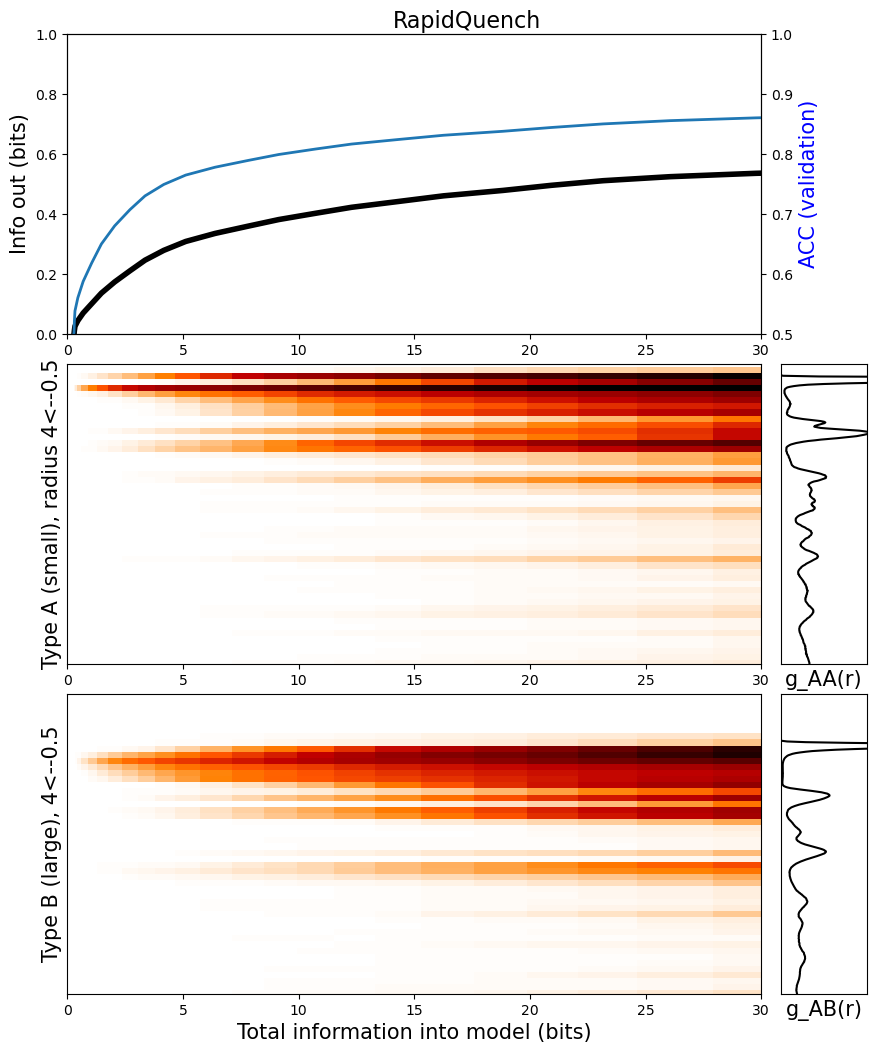

In [16]:
  ##############################################################################
  ## Plot the info allocation over time (Fig 2 in the manuscript)
  ##############################################################################
  print('*'*100)
  print('Finished training, painting the information allocation heat map.')
  print('*'*100)

  # We don't care about the finished model, we care about what happened along
  # the way.  Retrieve various things from the callbacks
  info_per_feature_bounds = np.float32(info_per_feature_callback.bounds)
  info_per_feature_bounds = np.reshape(info_per_feature_bounds, [-1, number_features, 2])/np.log(2)

  beta_series = np.float32(history.history['beta'])
  kl_series = np.stack([history.history[f'val_KL{feature_ind}'] for feature_ind in range(number_features)], -1)
  val_bce_series = np.float32(history.history['val_loss'])
  acc_series = np.float32(history.history['val_accuracy'])
  ## Get the original bce loss without the KL term
  val_bce_series -= beta_series * np.sum(kl_series, axis=-1)
  val_bce_series /= np.log(2)
  if save_outputs:
    np.savez(f'history_{protocol}.npz',
            betas=beta_series,
            validation_bce=val_bce_series,
            acc_validation=acc_series,
            info_per_feature_bounds=info_per_feature_bounds)
  ############################################################################################
  if stash_embeddings_for_distinguishability_matrices:
    emb_mu_history = np.reshape(embeddings_callback.mus_for_later, [-1, number_features, valX.shape[0], feature_embedding_dimension])
    emb_logvar_history = np.reshape(embeddings_callback.logvars_for_later, [-1, number_features, valX.shape[0], feature_embedding_dimension])
    if save_outputs:
      np.save(os.path.join(expt_outdir, 'embs_mus_history.npy'), emb_mu_history)
      np.save(os.path.join(expt_outdir, 'embs_logvars_history.npy'), emb_logvar_history)

  ## Plot stuff
  info_in_plot_lims = [0, None]
  info_per_feature_plot_lims = [0, 2]
  accuracy_plot_lims = [0.8, None]

  smoothing_sigma = 0.1
  info_in_parts = nim.filters.gaussian_filter1d(np.mean(info_per_feature_bounds, axis=-1), smoothing_sigma, axis=0)
  info_in_full = np.sum(info_in_parts, axis=-1)
  validation_bce_series = nim.filters.gaussian_filter1d(val_bce_series, smoothing_sigma)
  acc_validation_series = nim.filters.gaussian_filter1d(acc_series, smoothing_sigma)

  ####################################################### Create the info matrix
  g_r_AA = np.load(f'g_r_AA_{protocol}.npy')
  g_r_AB = np.load(f'g_r_AB_{protocol}.npy')
  g_r_bins = np.load('g_r_bins.npy')

  info_series = np.mean(info_per_feature_bounds, axis=-1)

  # Smooth the data from the optimization run a little
  smoothing_sigma_info_parts = 1
  smoothing_sigma_info_full = 0.5
  smoothing_sigma_outs = 2.5
  info_in_parts = nim.filters.gaussian_filter1d(info_series, smoothing_sigma_info_parts, axis=0)
  info_in_full = nim.filters.gaussian_filter1d(np.sum(info_series, axis=-1), smoothing_sigma_info_full)

  info_total_limit = 30
  info_in_plot_lims = [0, info_total_limit]
  info_out_plot_lims = [0, 1]
  info_color_lims = [0, 1.5]
  acc_plot_lims = [0.5,1]
  g_r_lims = [0, 2]
  r_plot_lims = [radius_max, radius_min]
  info_cmap = 'gist_heat_r'

  horizontal_cutoff_index = np.where(info_in_full>info_total_limit)[0][-1]

  horizontal_positions = info_in_full[horizontal_cutoff_index:]
  vertical_positions = np.linspace(radius_min, radius_max, number_radial_densities_per_type)

  infos = info_in_parts[horizontal_cutoff_index:]

  ########################################################## PLOT
  if smoothing_sigma_outs > 0:
    validation_bce_series = nim.filters.gaussian_filter1d(val_bce_series, smoothing_sigma_outs)
    acc_validation_series = nim.filters.gaussian_filter1d(acc_series, smoothing_sigma_outs)
  else:
    validation_bce_series = val_bce_series
    acc_validation_series = acc_series
  entropy_y_validation = 1.
  info_out = entropy_y_validation - validation_bce_series

  fig = plt.figure(figsize=(10, 12))
  gs = fig.add_gridspec(3, 2, height_ratios=(1, 1, 1), width_ratios=(8, 1),
                    left=0.1, right=0.9, bottom=0.1, top=0.9,
                    wspace=0.05, hspace=0.1)

  ax = fig.add_subplot(gs[0, 0])
  ax.plot(info_in_full, info_out[::mi_save_frequency], lw=4, color='k')
  ax.set_ylim(info_out_plot_lims)
  ax.set_xlim(info_in_plot_lims)
  ax.set_xlabel("Info in (bits)", fontsize=15)
  ax.set_ylabel("Info out (bits)", fontsize=15)

  ax2 = ax.twinx()
  ax2.plot(info_in_full, acc_validation_series[::mi_save_frequency], lw=2)
  ax2.set_ylabel("ACC (validation)", fontsize=15, color='b')
  ax2.set_ylim(acc_plot_lims)

  ###################################### Info allocation matrix

  ax1 = fig.add_subplot(gs[1, 1])
  ax1.plot(g_r_AA, g_r_bins[1:], 'k')
  ax1.set_xlim(g_r_lims)
  ax1.set_ylim(r_plot_lims)
  plt.xticks([]); plt.yticks([])

  ax1.set_xlabel('g_AA(r)', fontsize=15)

  ax2 = fig.add_subplot(gs[1, 0])
  im = NonUniformImage(ax2, interpolation='nearest', extent=(horizontal_positions.min(), horizontal_positions.max(), radius_max, radius_min),
                      cmap=info_cmap)
  im.set_data(horizontal_positions[::-1],
              vertical_positions,
              infos[::-1, :number_radial_densities_per_type].T[::-1])
  ax2.add_image(im)
  ax2.set_xlim(info_in_plot_lims)
  ax2.set_ylim(r_plot_lims[::-1])
  ax2.set_yticks([])
  im.set_clim(info_color_lims)
  ax2.set_ylabel(f'Type A (small), radius {radius_max}<--{radius_min}', fontsize=15)

  ax3 = fig.add_subplot(gs[2, 1])
  ax3.plot(g_r_AB, g_r_bins[1:], 'k')
  ax3.set_xlim(g_r_lims)
  ax3.set_ylim(r_plot_lims)
  plt.xticks([]); plt.yticks([])
  ax3.set_xlabel('g_AB(r)', fontsize=15)

  ax4 = fig.add_subplot(gs[2, 0])
  im = NonUniformImage(ax4, interpolation='nearest', extent=(horizontal_positions.min(), horizontal_positions.max(), radius_max, radius_min),
                      cmap=info_cmap)
  im.set_data(horizontal_positions[::-1],
              vertical_positions,
              infos[::-1, number_radial_densities_per_type:].T[::-1])
  ax4.add_image(im)
  ax4.set_xlim(info_in_plot_lims)
  ax4.set_ylim(r_plot_lims[::-1])
  ax4.set_yticks([])
  im.set_clim(info_color_lims)
  ax4.set_xlabel('Total information into model (bits)', fontsize=15)
  ax4.set_ylabel(f'Type B (large), {radius_max}<--{radius_min}', fontsize=15)

  plt.suptitle(protocol, fontsize=16, y=0.92)
  if save_outputs:
    plt.savefig(f'info_decomp_{protocol}.png')
  plt.show()

/var/folders/_g/c280fyld6p995vl8sfv61gn40000gn/T/ipykernel_20260/3744980646.py:9: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  approx_info_in_full = nim.filters.gaussian_filter1d(np.sum(info_series, axis=-1), smoothing_sigma_info_full)


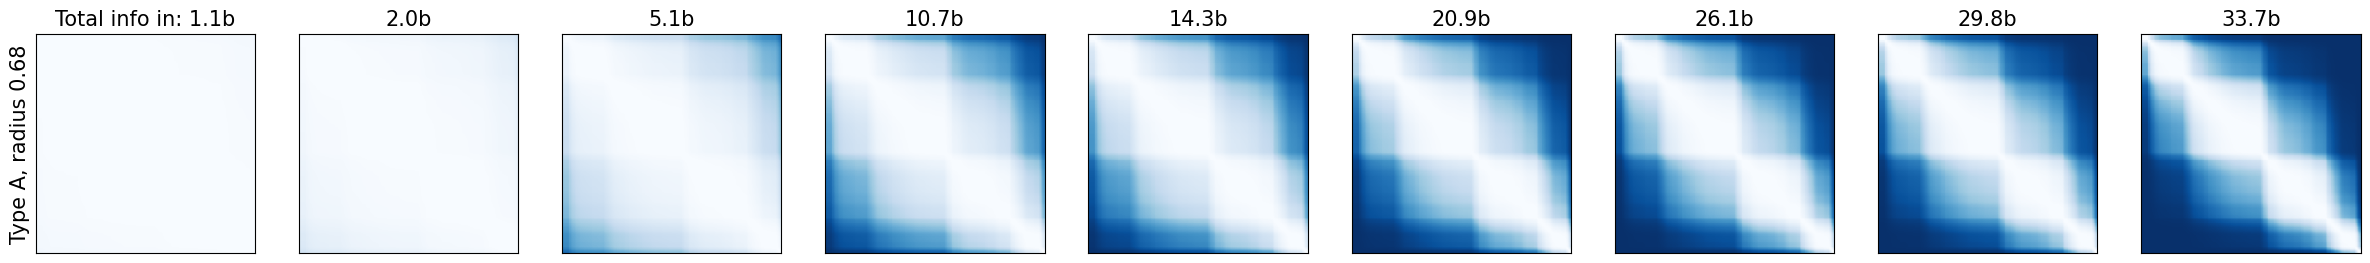

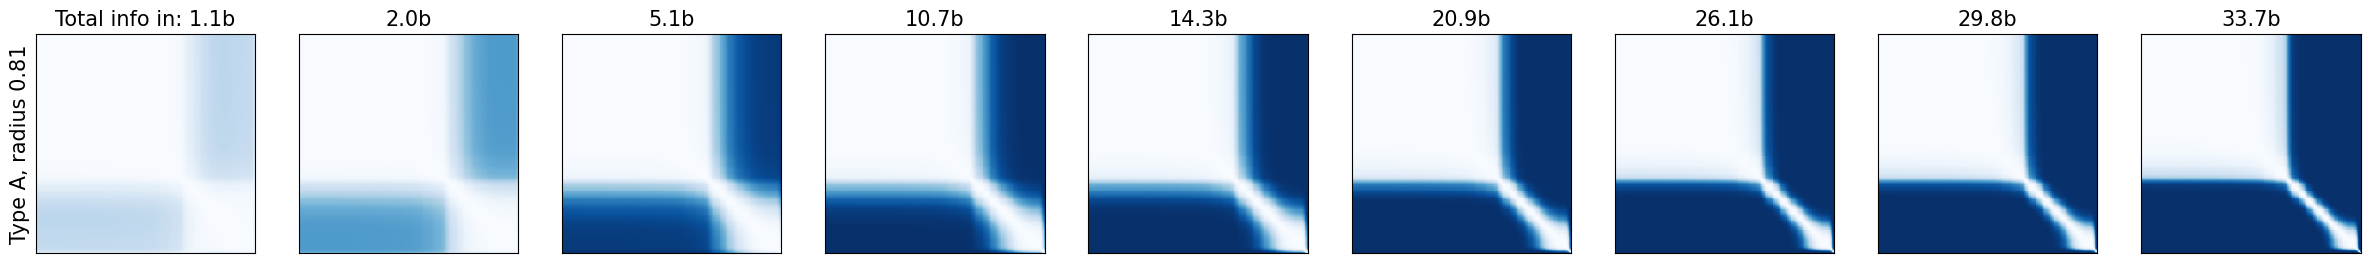

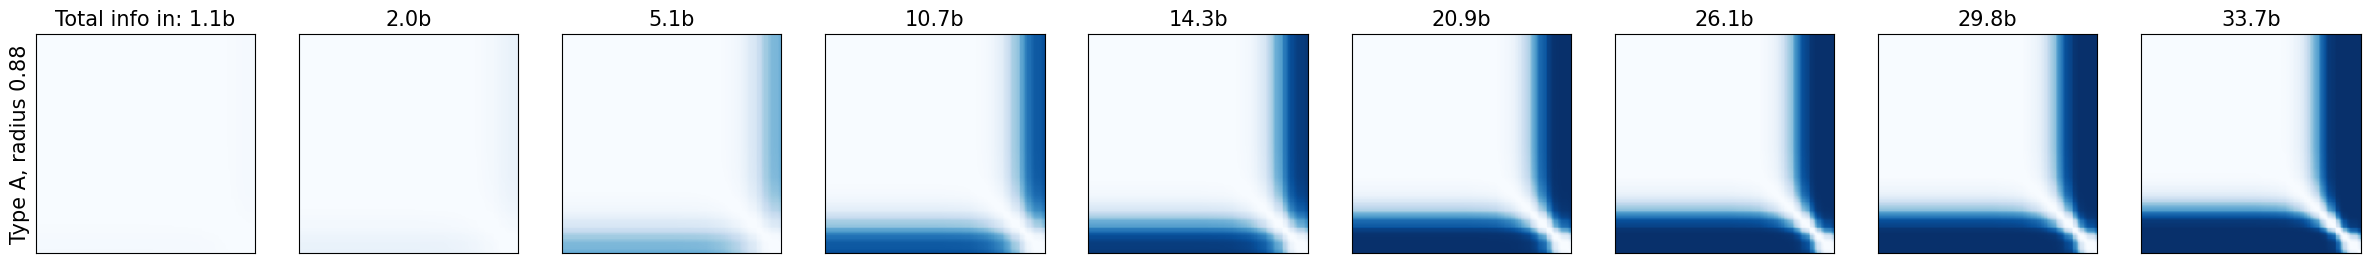

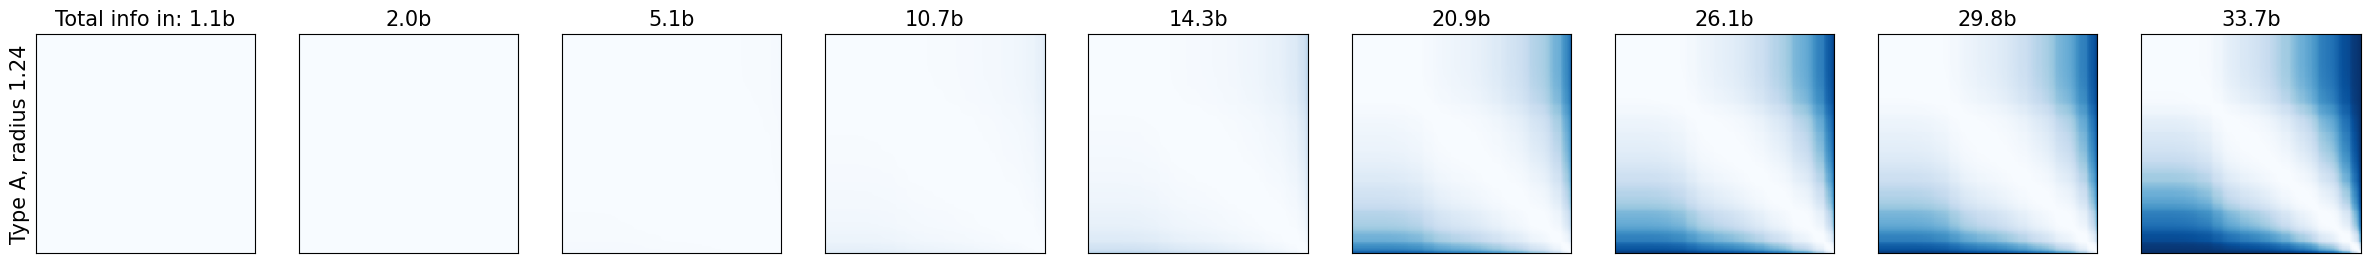

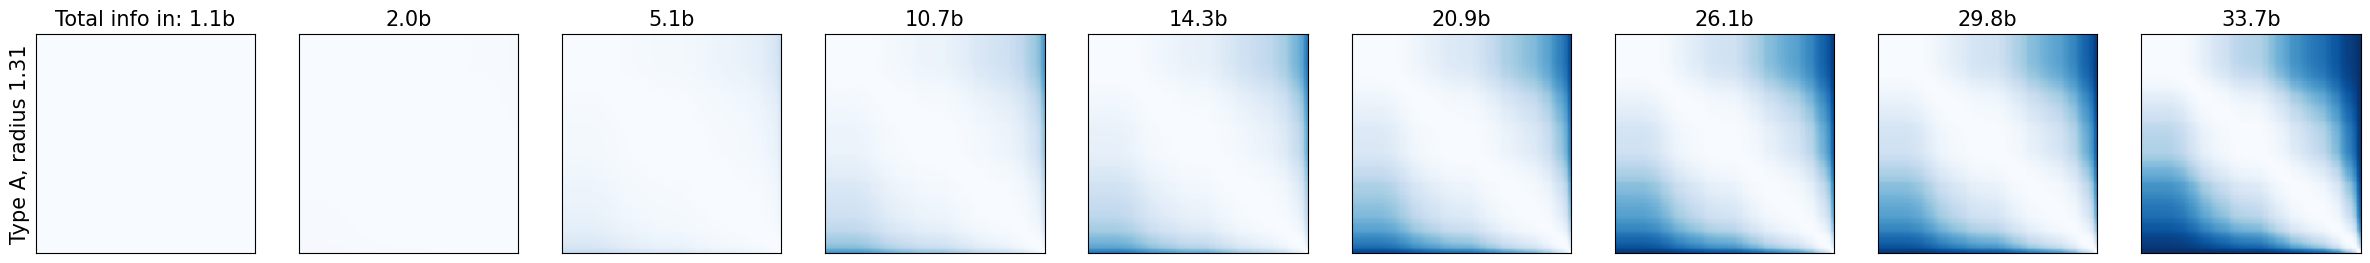

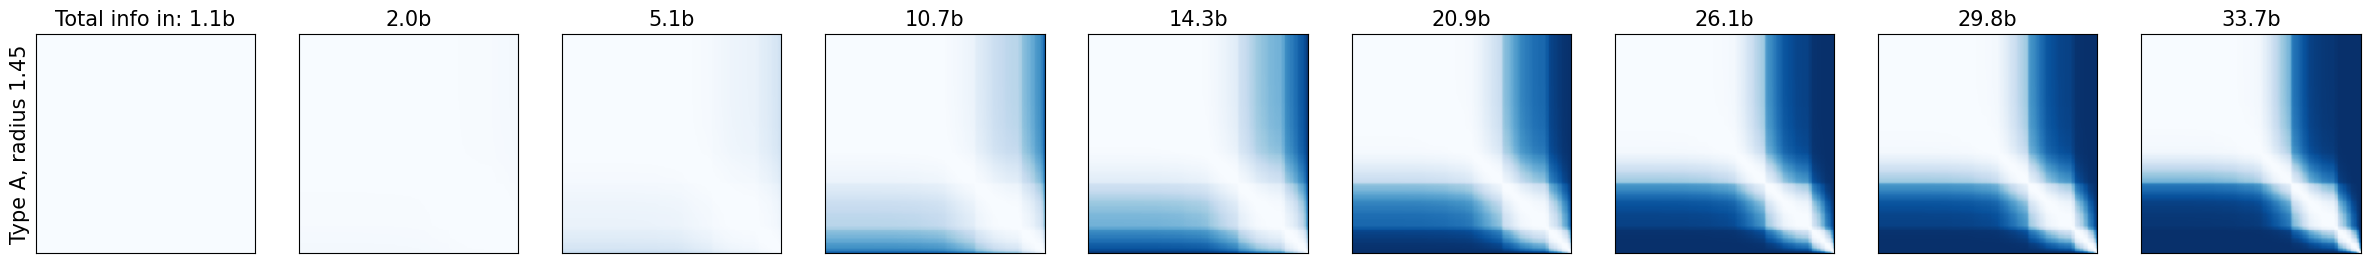

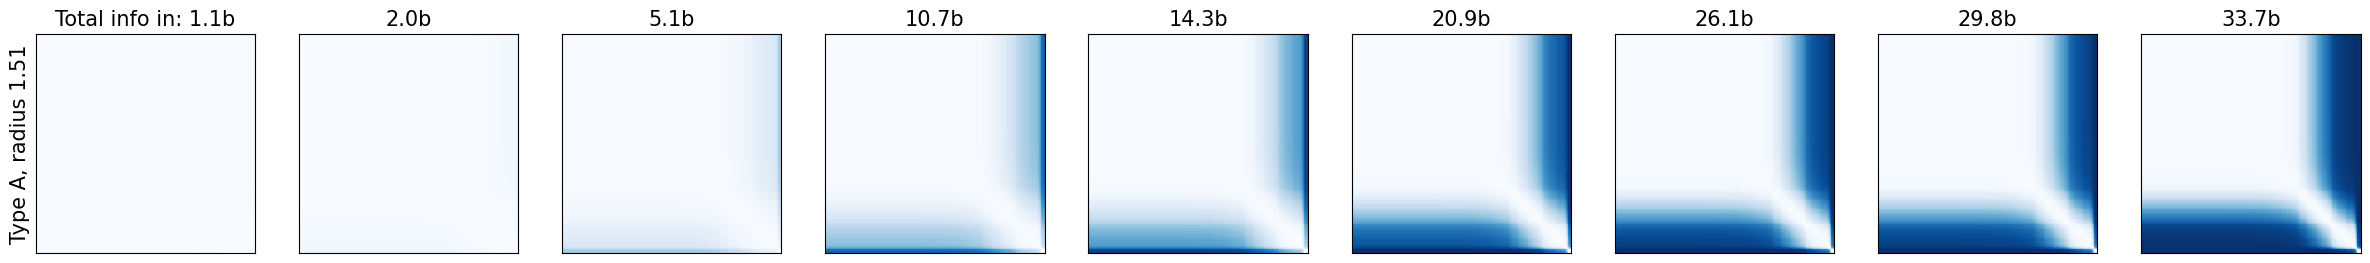

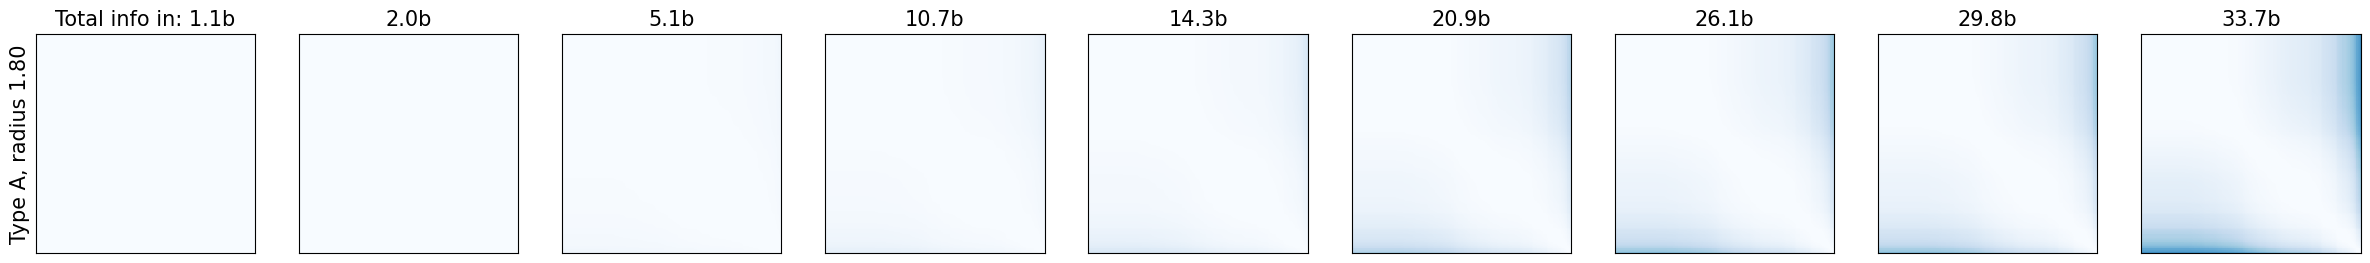

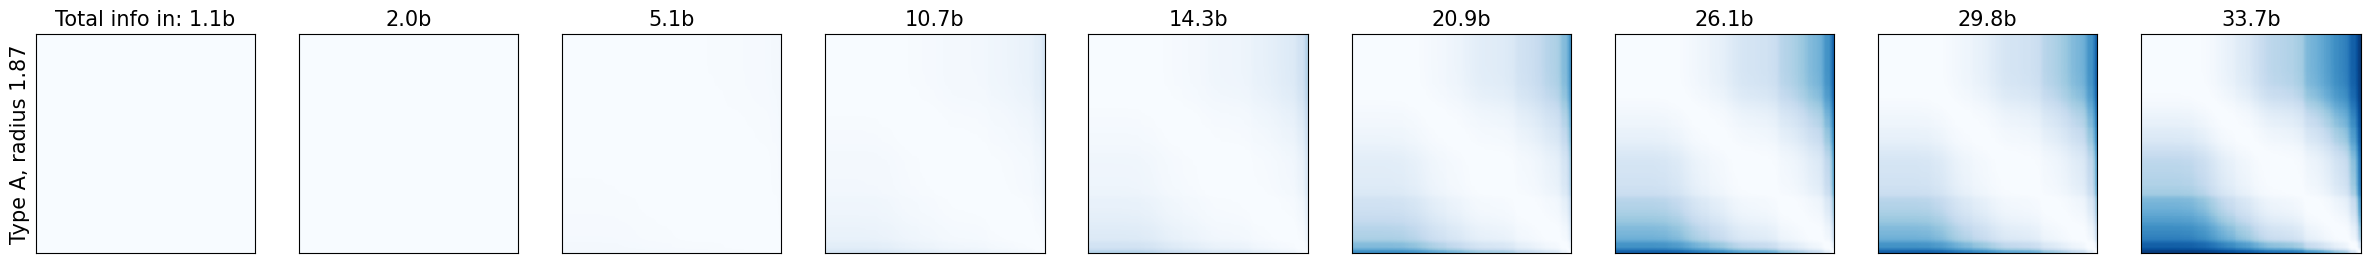

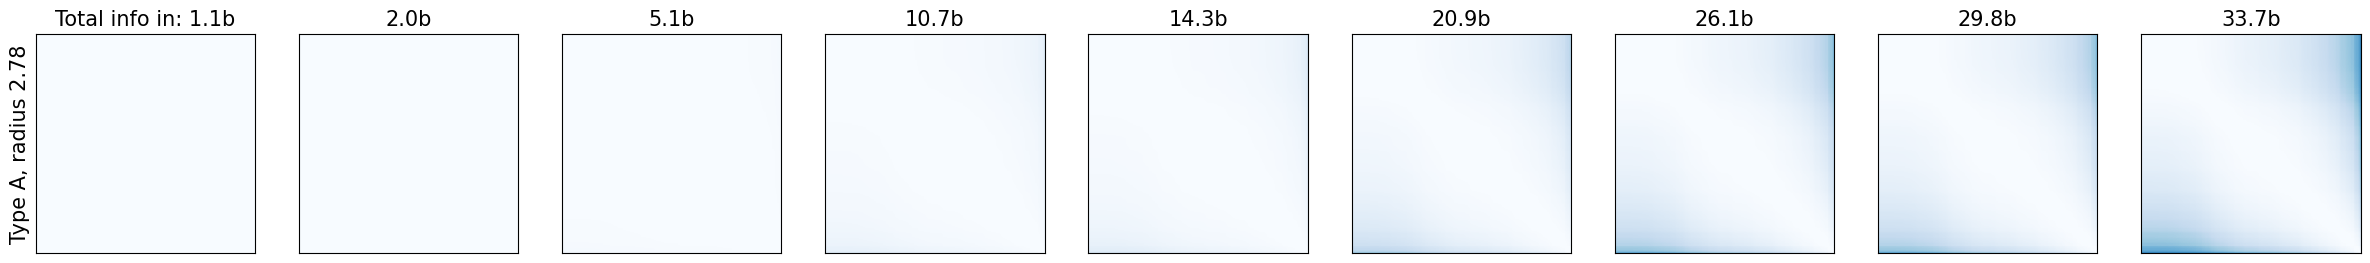

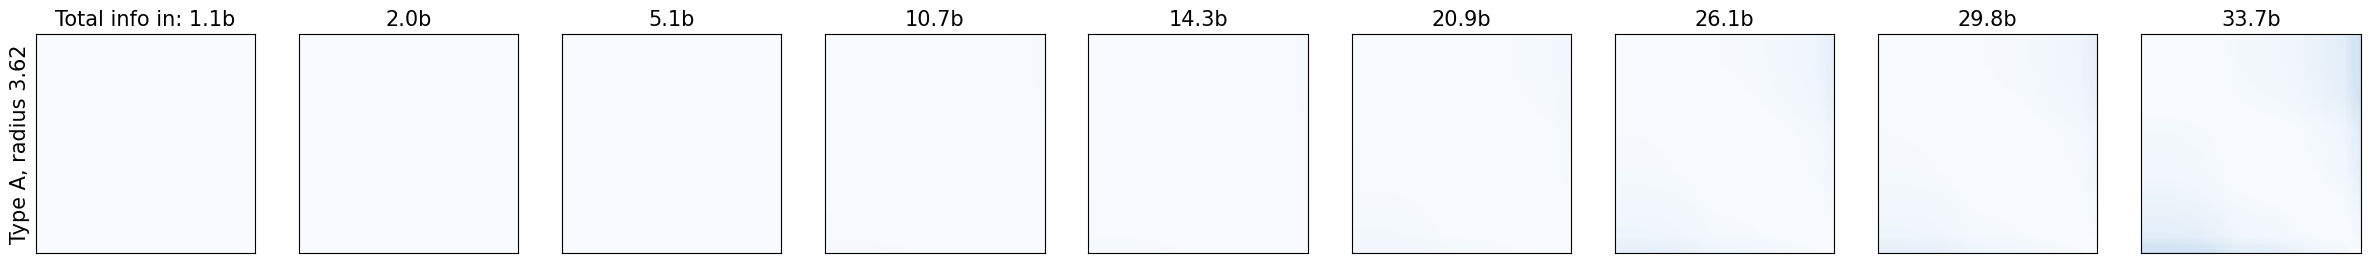

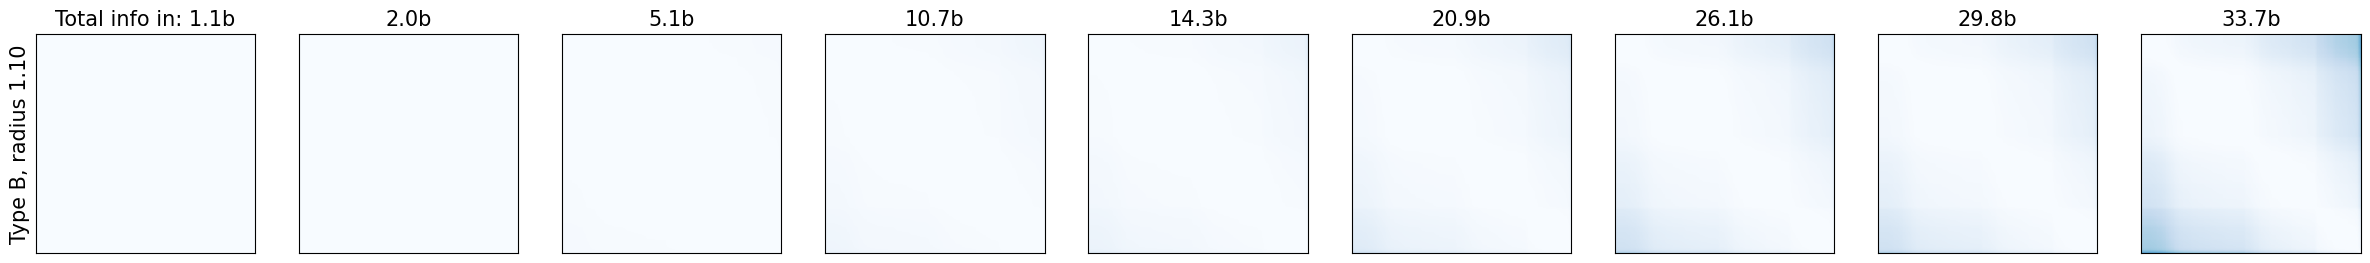

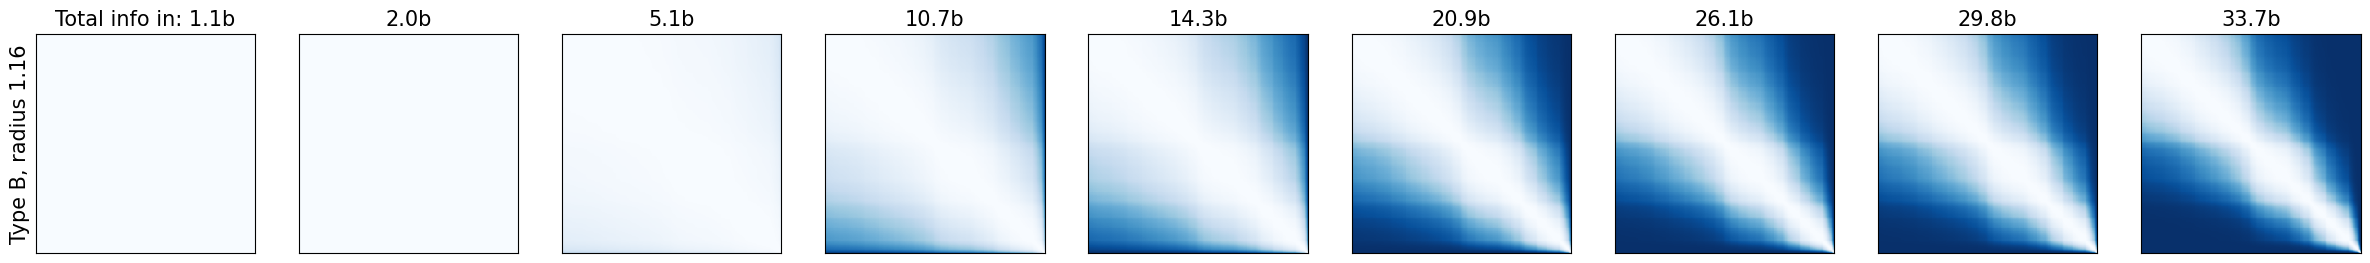

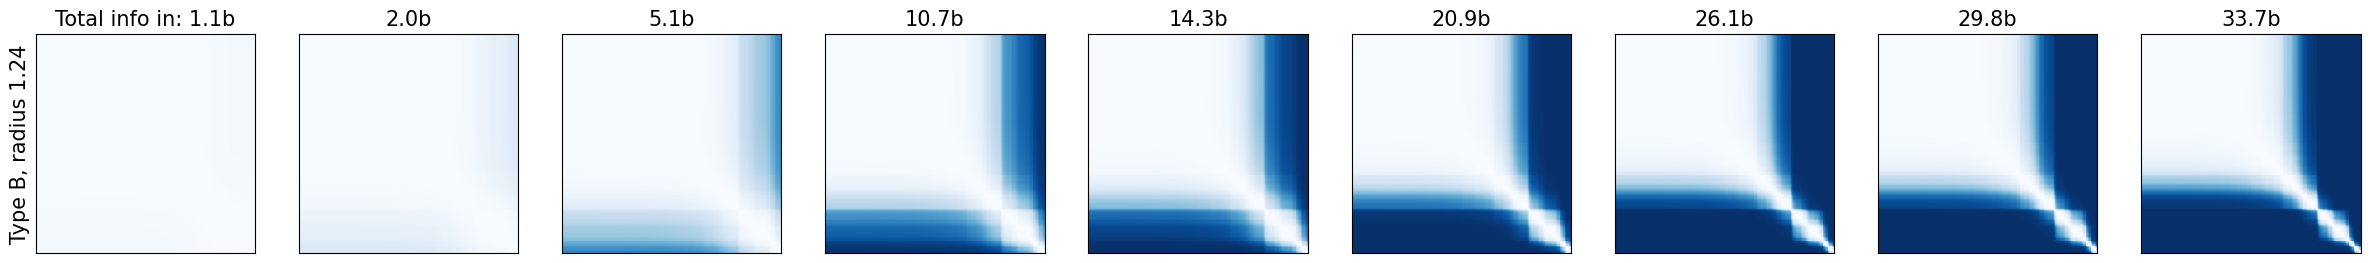

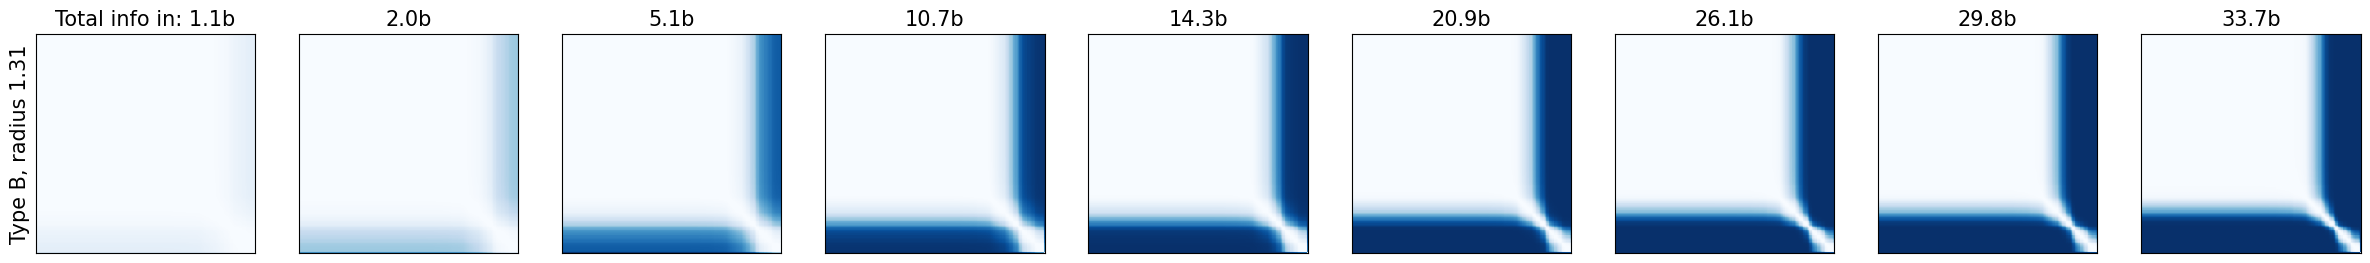

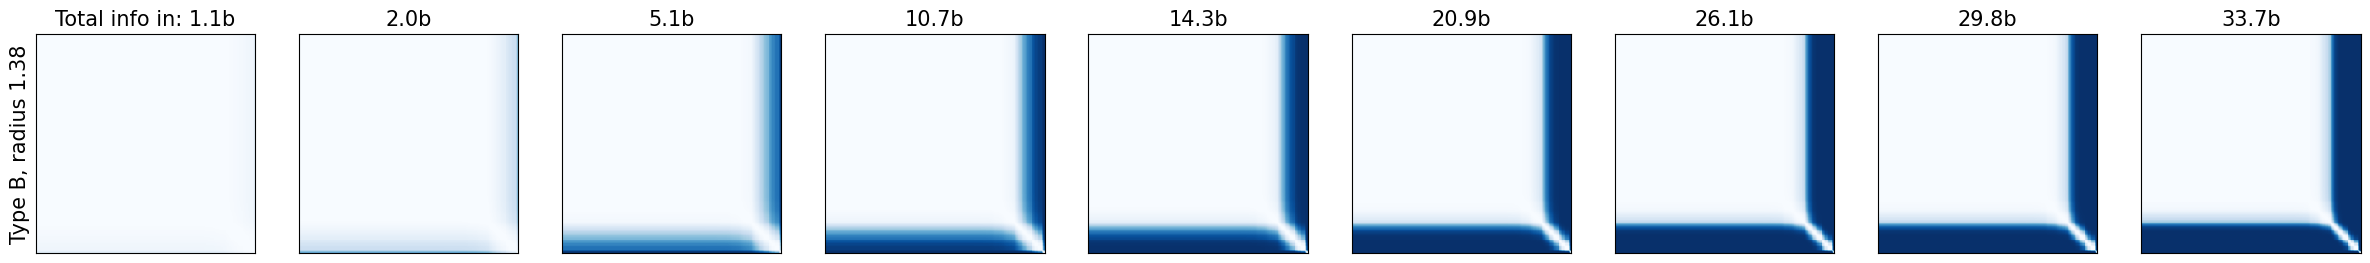

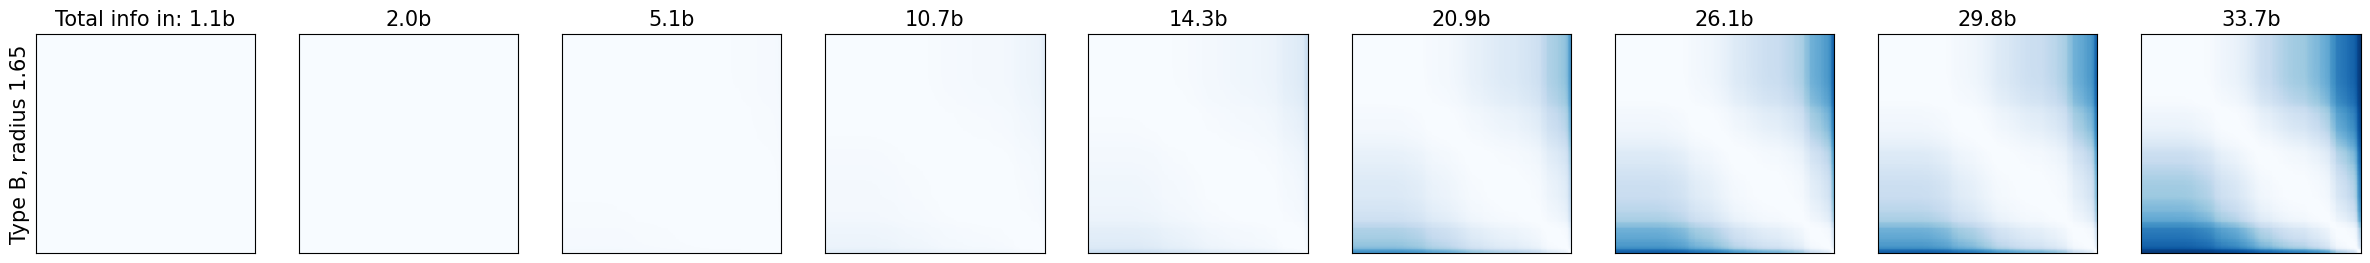

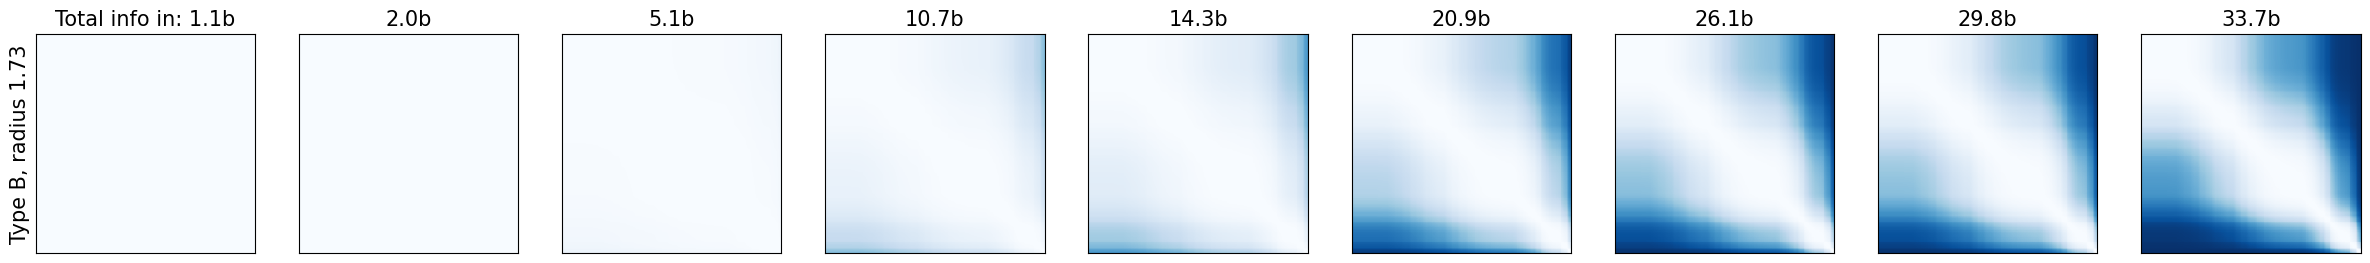

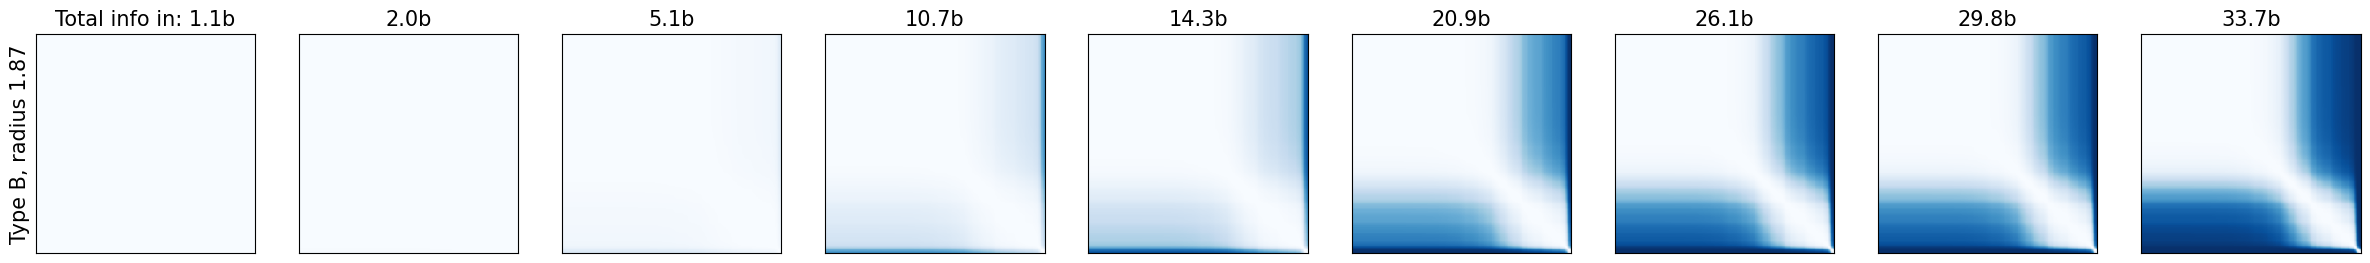

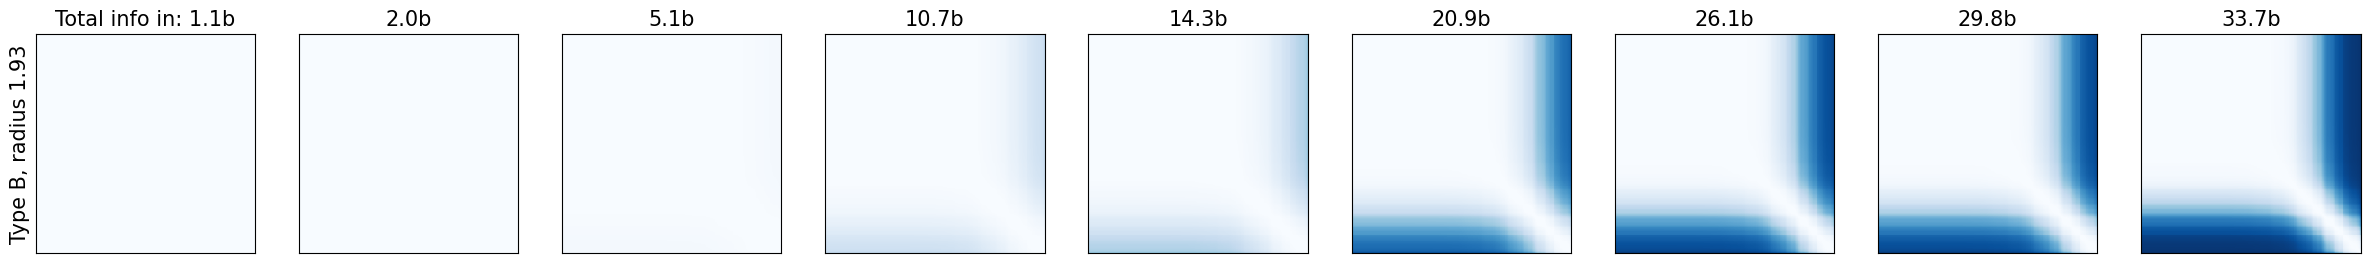

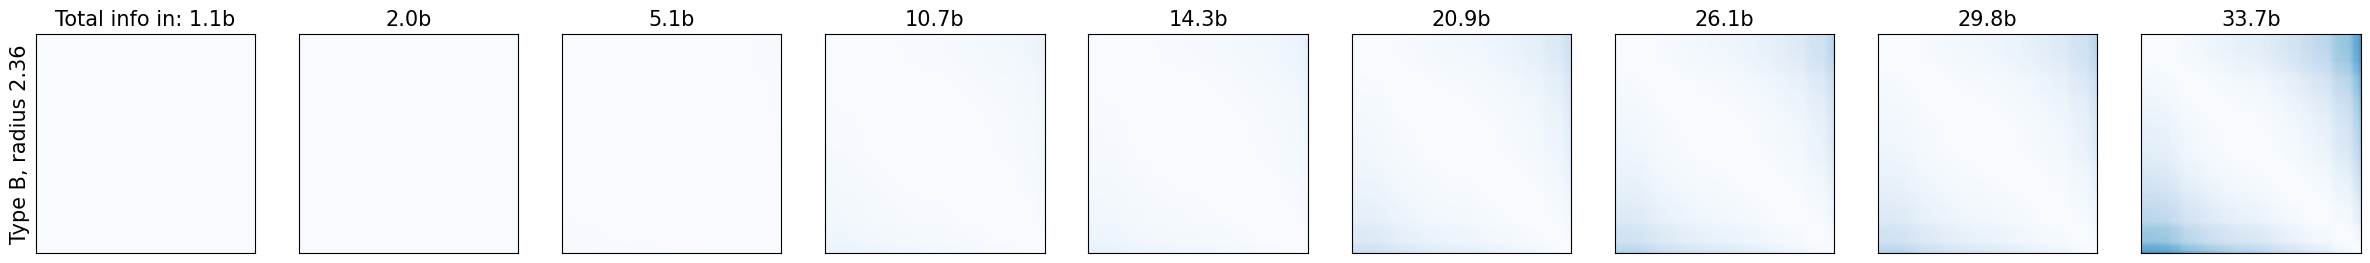

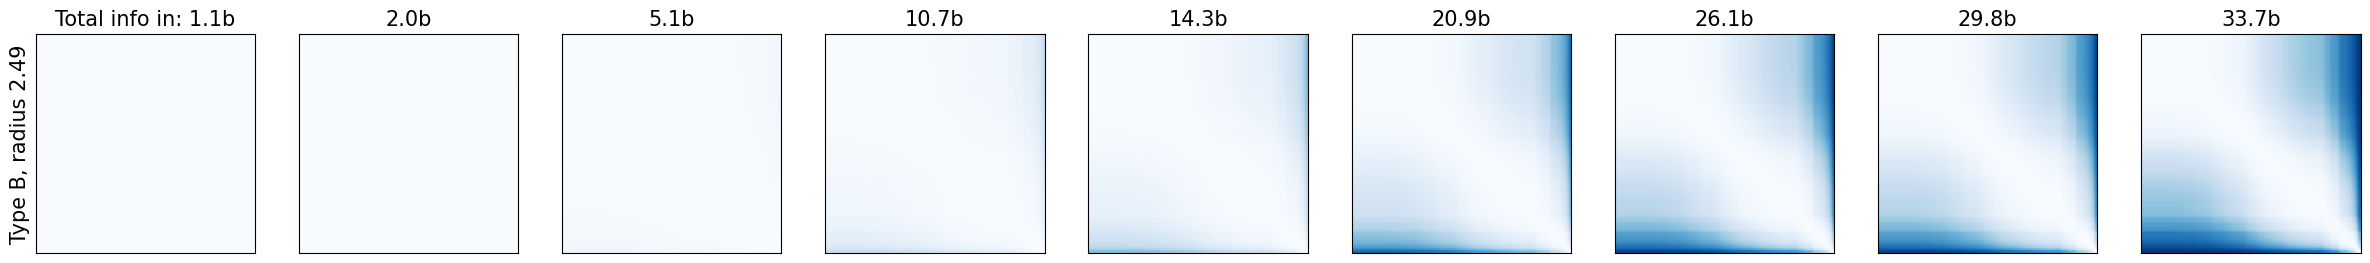

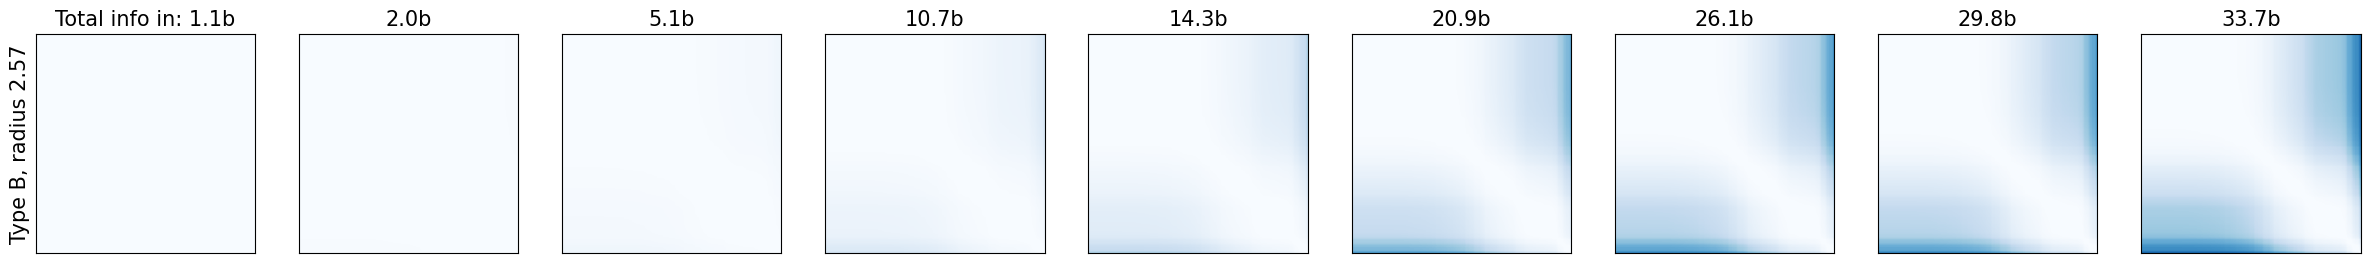

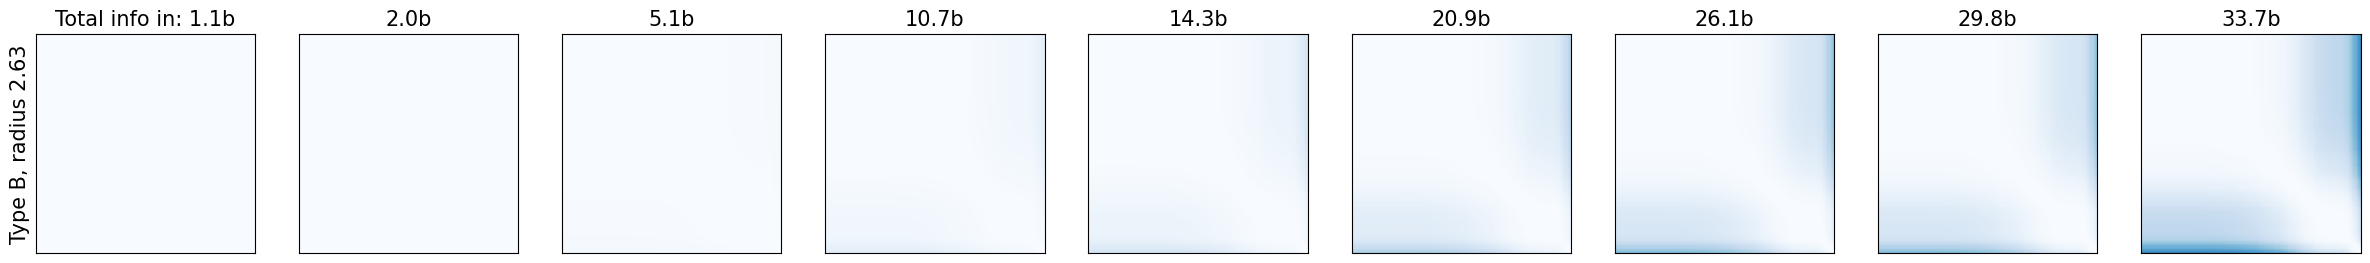

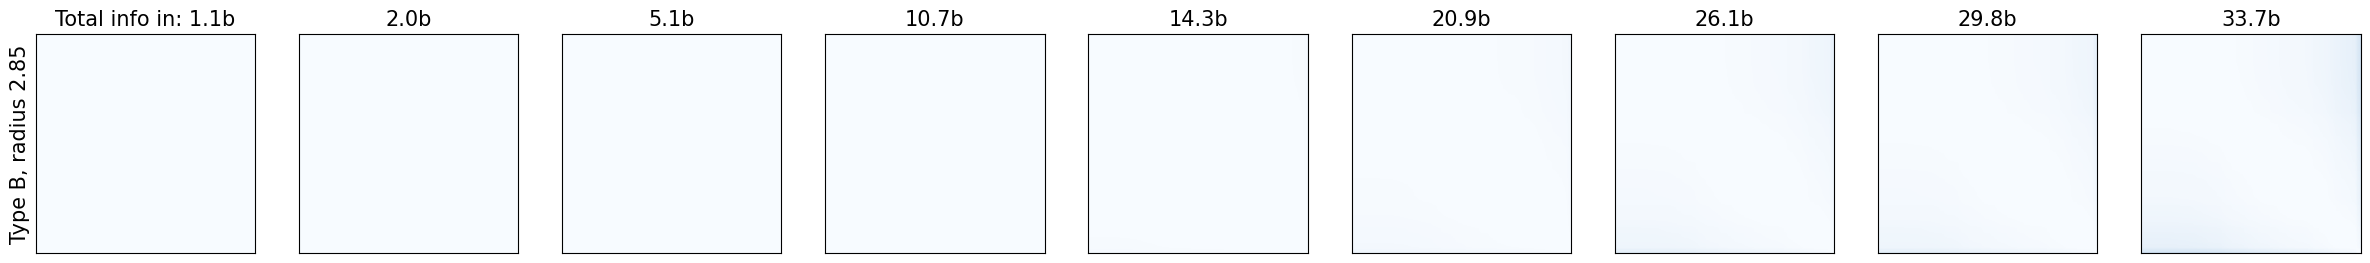

In [17]:
  if stash_embeddings_for_distinguishability_matrices:
    ##############################################################################
    ## Display the distinguishability matrices between feature values (Fig 3)
    ##############################################################################
    # Values of the total information utilized (in bits) for which to plot the dist mats
    desired_info_vals = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]

    smoothing_sigma_info_full = 0.5
    approx_info_in_full = nim.filters.gaussian_filter1d(np.sum(info_series, axis=-1), smoothing_sigma_info_full)

    # Get the timestep indices that most closely match the desired info vals
    info_dist_mat_inds, emb_dist_mat_inds = [[], []]
    for val in desired_info_vals:
      forward_info_ind = np.argmin(np.abs(approx_info_in_full-val))
      info_dist_mat_inds.append(forward_info_ind)
      # Count backward because we started saving embeddings after a delay
      backward_emb_ind = (forward_info_ind - number_annealing_epochs) * (mi_save_frequency / embeddings_save_frequency)
      emb_dist_mat_inds.append(int(backward_emb_ind))
    emb_dist_mat_inds = [val for val in emb_dist_mat_inds if np.abs(val)<emb_mu_history.shape[0]]
    dist_mat_info_in_vals = approx_info_in_full[info_dist_mat_inds]

    for feature_ind in range(number_features):
      dist_mat_cmap = 'Blues_r'
      number_samples_from_validation_set = 256
      inches_per_subplot = 3

      # Don't worry about plotting it if there's no info even at the high end
      if info_series[info_dist_mat_inds[-1], feature_ind] < 0.5:
        continue
      plt.figure(figsize=(inches_per_subplot*len(desired_info_vals), inches_per_subplot))
      for plt_ind, (emb_dist_mat_ind, dist_mat_info_in_val) in enumerate(zip(emb_dist_mat_inds, dist_mat_info_in_vals)):
        plt.subplot(1, len(emb_dist_mat_inds), plt_ind+1)
        orig_X_vals = valX[:number_samples_from_validation_set, feature_ind]
        sorted_inds = np.argsort(orig_X_vals)
        mus_sorted = emb_mu_history[emb_dist_mat_ind, feature_ind, :number_samples_from_validation_set][sorted_inds]
        logvars_sorted = emb_logvar_history[emb_dist_mat_ind, feature_ind, :number_samples_from_validation_set][sorted_inds]

        bhat_dist_mat = bhattacharyya_dist_mat(mus_sorted,
                                              logvars_sorted,
                                              mus_sorted,
                                              logvars_sorted)
        bhat_coeff_mat = np.exp(-bhat_dist_mat)

        plt.imshow(bhat_coeff_mat, vmin=0, vmax=1, cmap=dist_mat_cmap)
        if not plt_ind:
          plt.ylabel(f'Type {"AB"[feature_ind//number_radial_densities_per_type]}, radius {radii[0, feature_ind%number_radial_densities_per_type]:.2f}', fontsize=15)
          plt.title(f'Total info in: {dist_mat_info_in_val:.1f}b', fontsize=15)
        else:
          plt.title(f'{dist_mat_info_in_val:.1f}b', fontsize=15)
        plt.xticks([]); plt.yticks([])

      if save_outputs:
        plt.savefig(os.path.join(expt_outdir, f'dist_mats_feature_{feature_ind}.png'))

      plt.show()